# Creating Loneliness Index from Prescription Data for Scotland

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
# Path to files
path = "data-raw/Scotland/"

# Read drug data

In [5]:
# Get drug data (NB some drugs duplicated for illnesses)
drug_data = pd.read_csv("drug_list.csv")

# Process Prescribing Data

This code iterates over the monthly prescribing data, producing an aggregate table.

**Filename format:** pitc[year][month].csv (e.g. pitc201801.csv)

**Columns:** HBT, GPPractice, BNFItemCode, BNFItemDescription, ClassOfPreparationCode, NumberOfPaidItems, PaidQuantity, GrossIngredientCost, PaidDateMonth

These files are the "Prescriptions in the Community" .csv files that come from: https://www.opendata.nhs.scot/dataset/prescriptions-in-the-community

In [6]:
# column names
col_bnfname = "BNFItemDescription"
col_items = "NumberOfPaidItems"

In [7]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x[col_bnfname].str.contains("|".join(drug_data['medication'].unique()),
                                                  case = False, 
                                                  regex = True).fillna(False).astype('int16')
    # Return dataframe multiplied by counts of items
    return out.multiply(x[col_items], axis=0)

In [8]:
# Make dictionary for aggregation
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
agg_cols['loneliness'] = 'sum'
for key in ['Date', 'HBT']:
    agg_cols[key] = 'first'

In [9]:
monthly_data = []

for file in os.listdir(path + "Prescriptions"):
    # Open prescribing files in pandas.
    prescribe = pd.read_csv(path + "Prescriptions\\" + file)
    prescribe.columns = prescribe.columns.str.strip()
    # Rename 'PaidDateMonth' column to 'date'
    prescribe.rename(columns = {'PaidDateMonth': 'Date'}, inplace = True) 
    # Get counts of prescribing dataframe for loneliness related diseases
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    # merge dataframes
    prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
    del loneliness_prescribing
    # get a summary - grouping by GPPractice
    summary = prescribe.groupby('GPPractice', as_index=False).agg(agg_cols)
    monthly_data.append(summary)
    print(file)


pitc202201.csv
pitc202202.csv
pitc202203.csv
pitc202204.csv
pitc202205.csv
pitc202206.csv
pitc202207.csv
pitc202208.csv
pitc202209.csv
pitc202210.csv
pitc202211.csv
pitc202212.csv


In [10]:
# concatenate all the monthly data together
data = pd.concat(monthly_data, ignore_index = True)

In [11]:
data[data["loneliness"] > 0].head()

,GPPractice,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,Date,HBT
0,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030
1,10017,550,35,658,664,89,420,56,0,5,8734,1814,202201,S08000030
2,10036,376,11,579,582,62,344,59,0,6,6136,1434,202201,S08000030
3,10106,513,34,719,724,106,505,39,1,2,8541,1922,202201,S08000030
4,10125,425,15,453,454,91,367,44,0,4,6673,1396,202201,S08000030


In [12]:
# Save aggregated data
data.to_csv(path + "processed_data.csv")

# Import GP Practices and Postcode

Use the 'GP Practice Contact Details and List Sizes' data from: https://www.opendata.nhs.scot/dataset/gp-practice-contact-details-and-list-sizes to get GP surgery codes and postcode

Note that Scotland only publishes these data four times a year (in Jan, Apr, Jul and Oct).

**Filename format:** gppractices[year][month][day].csv (e.g. gppractices20180101.csv)

**Columns:** PracticeCode, PracticeName, PracticeListSize, AddressLine1, AddressLine2, AddressLine3, AddressLine4, Postcode, TelephoneNumber, PracticeType, Dispensing, HB2014 [Health Board], HB1995 [Health Board], HSCP2016 [Health and Social Care Partnership], CA2011 [Council Area], DZ2011 [Data Zone], DZ2001 [Data Zone]

In [43]:
data = pd.read_csv(path + "processed_data.csv", index_col = 0)

In [44]:
# Get GP files
gp_path = path + "GP data/"

In [45]:
gp_combine = []

for file in os.listdir(gp_path):
    gp_data = pd.read_csv(gp_path + file)
    gp_data = gp_data.rename(columns = {'PracticeCode': 'GPPractice'})
    gp_combine.append(gp_data[['GPPractice','Postcode']])
    print(file)

gppractices20220101.csv
gppractices20220701.csv
gppractices20221001.csv


In [46]:
# concatenate all the gp data together
gp_data = pd.concat(gp_combine, ignore_index = True)

In [47]:
gp_data.head(3)

,GPPractice,Postcode
0,10002,DD2 5NH
1,10017,PH7 3SA
2,10036,PH15 2BL


In [48]:
# Get the unique codes for GP surgeries and subset the prescribing data according to these codes.
gp_ids = gp_data['GPPractice'].unique()
data = data[data['GPPractice'].isin(gp_ids)].copy()
data.shape

(11121, 14)

In [49]:
# Merge on the basis GPPractice code
data = data.merge(gp_data, how = 'left', on = ['GPPractice'])

In [50]:
data.head(2)

,GPPractice,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,Date,HBT,Postcode
0,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030,DD2 5NH
1,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030,DD2 5NH


In [51]:
data.Postcode.isna().value_counts()

Postcode
False    32836
Name: count, dtype: int64

In [52]:
# Create uniform postcode field
data['pcstrip'] = data['Postcode'].str.replace("\s","").str.replace(" ","")

In [53]:
# Check all GPs have postcode
data.pcstrip.isna().value_counts()

pcstrip
False    32836
Name: count, dtype: int64

In [54]:
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('GPPractice')['pcstrip'].unique().map(len)
pc_prac_counts[pc_prac_counts > 1].count()

12

In [55]:
pc_prac_counts[pc_prac_counts > 1].value_counts()

pcstrip
2    12
Name: count, dtype: int64

In [56]:
(pc_prac_counts[pc_prac_counts > 1].count())/data.GPPractice.nunique()


0.012861736334405145

Some Practice Codes have more than one postcode associated with them. Possible reasons for this are:
* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

There are 12 practices codes which have more than 1 postcode assigned to them, this is about 1.3% of unique practices.

All 12 practices have 2 postcodes associated with them.

We'll ignore this for now - this will require some more advanced cleaning - useful to be aware of though.

In [57]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcode.csv")

# Generate Statistics from Prescribing Counts

- Aggregate observations to postcodes and compute percentages per conidtion
- Compute z-score per condition
- Add z-scores of all conditions together to compute a loneliness score
- Use min-max scaler for -1 to 1 normalisation
- Use decile normalisation

To consider for the future
- Should we remove some GPs on the basis that they have very low/high values which might indicate they are not accessible to the general population, and instead represent specialist services?
- When adding more years, should the earlier year observed be the baseline and subsequent z scores are calculated wrt to baseline mean and sd?


In [62]:
data = pd.read_csv(path + "processed_data_with_postcode.csv", index_col=0)

In [63]:
data = data.drop(columns = ['Date','HBT','Postcode','GPPractice'])
data

,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,pcstrip
0,594,20,700,704,107,485,41,0,3,9510,1951,DD25NH
1,594,20,700,704,107,485,41,0,3,9510,1951,DD25NH
2,594,20,700,704,107,485,41,0,3,9510,1951,DD25NH
3,550,35,658,664,89,420,56,0,5,8734,1814,PH73SA
4,550,35,658,664,89,420,56,0,5,8734,1814,PH73SA
...,...,...,...,...,...,...,...,...,...,...,...,...
32831,583,11,859,870,115,469,54,0,1,10120,2102,HS12XB
32832,583,11,859,870,115,469,54,0,1,10120,2102,HS12XB
32833,698,26,1110,1125,139,763,72,0,9,12226,2823,HS29JP
32834,698,26,1110,1125,139,763,72,0,9,12226,2823,HS29JP


In [64]:
data = data.groupby(['pcstrip'], as_index = False).sum()

In [65]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups out of total drugs prescribed
data[target_cols] = data[perc_cols].divide(data[col_items], axis=0) * 100

# Overall percentage for loneliness realted disease prescribing out of total drugs prescribed
data['loneliness_perc'] = data['loneliness'].divide(data[col_items], axis=0) * 100

In [66]:
data.head(3)

,pcstrip,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc,loneliness_perc
0,AB101NW,27723,639,23877,24255,3861,15018,2142,324,450,...,7.485015,0.172526,6.446622,6.548680,1.042443,4.054755,0.578325,0.087478,0.121497,19.969221
1,AB101QB,26058,687,30867,31227,4281,20712,2484,873,2382,...,6.909444,0.182162,8.184581,8.280037,1.135134,5.491918,0.658648,0.231481,0.631602,22.888825
2,AB101UT,1359,24,1539,1561,218,1108,149,141,23,...,7.026524,0.124089,7.957189,8.070937,1.127139,5.728763,0.770384,0.729021,0.118918,23.576857


## Standardisation

In [67]:
# Calculate the z scores per illness

# Make new column names.
per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc']

# Calculate Z-scores for each column
for i, col in enumerate(per_cols):
    col_zscore = col[:-5] + 'zscore'  # New column name for Z-scores
    data[col_zscore] = stats.zscore(data[col])


In [68]:
# Add conditions z scores for overall loneliness z score
data['loneliness_zscore'] = data[[ 'depressionzscore', 'alzheimerszscore',
       'blood pressurezscore', 'hypertensionzscore', 'diabetieszscore',
       'cardiovascular diseasezscore', 'insomniazscore', 'addictionzscore',
       'social anxietyzscore']].sum(axis=1)

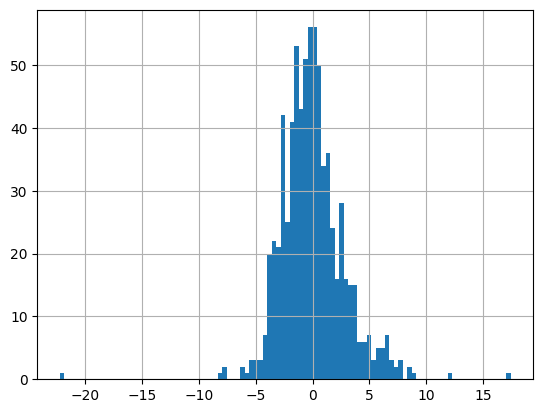

In [69]:
data.loneliness_zscore.hist(bins=100);

In [77]:
# Rank

data['ranked'] = data['loneliness_zscore'].rank()
data.ranked.describe()

count    739.00000
mean     370.00000
std      213.47521
min        1.00000
25%      185.50000
50%      370.00000
75%      554.50000
max      739.00000
Name: ranked, dtype: float64

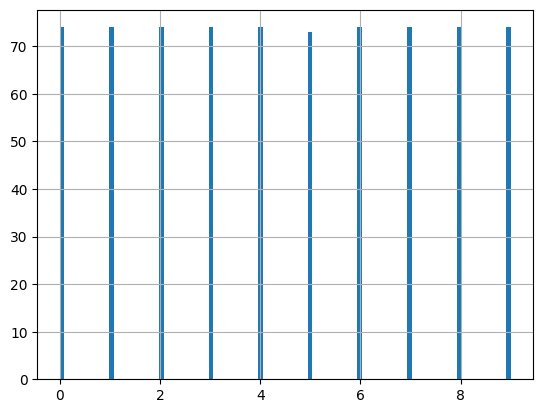

In [37]:
data['deciles'] = pd.qcut(data['loneliness_zscore'], q=10, labels=False)
data.deciles.hist(bins=100);

In [38]:
data.rename(columns={'pcstrip':'postcode'}, inplace = True)

In [39]:
data = data[['postcode','loneliness_zscore','scaled_1_1','deciles']]

In [42]:
data

,postcode,loneliness_zscore,scaled_1_1,deciles
0,AB101NW,-1.976918,-0.088928,2
1,AB101QB,7.784731,0.350182,9
2,AB101UT,2.910173,0.130909,8
3,AB101YE,1.201040,0.054027,7
4,AB107QQ,-1.605785,-0.072233,2
...,...,...,...,...
734,ZE29DY,5.641646,0.253779,9
735,ZE29HX,3.842246,0.172836,9
736,ZE29NA,6.571345,0.295600,9
737,ZE29QJ,8.485744,0.381716,9


In [40]:
# Save aggregated data
data.to_csv(path + "scotland_loneliness_2022.csv")